# Early game AFK Data Analysis

## Data

Import a preprocessed collection of data onall games from patch 13.18 on EUW server.

In [1]:
import pandas as pd

df = pd.read_pickle("df_all.pkl")

In [4]:
df

,p0_first_item_purchase,p1_first_item_purchase,p2_first_item_purchase,p3_first_item_purchase,p4_first_item_purchase,p5_first_item_purchase,p6_first_item_purchase,p7_first_item_purchase,p8_first_item_purchase,p9_first_item_purchase,...,participant_0,participant_1,participant_2,participant_3,participant_4,participant_5,participant_6,participant_7,participant_8,participant_9
0,9653,16184,19379,17352,13320,16951,14454,9387,7617,3989,...,3055773,3115783,470483,3932211,4369141,2504758,5042568,4086320,2258902,2932667
1,4344,10261,21626,8150,8084,8853,6984,25017,20214,10328,...,614066,4369141,2420613,4749236,695986,405248,2706109,3606551,2884276,755385
2,13905,28608,8930,19992,6945,7716,11895,12999,12430,3384,...,1663452,4369141,5647741,540462,5244896,1448127,2172214,2648104,2487279,4581288
3,15541,2735,18923,3037,5018,8197,15037,36838,13023,10780,...,1137872,4369141,43463,1569109,4956900,4485076,1143004,668350,590285,4041751
4,34676,10201,16857,2061,29118,5742,5141,38897,17994,14381,...,1010961,1127531,4178842,4861368,4767934,4227692,4369141,2100638,2823597,4823166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15403995,6780,6215,6181,4448,6581,1078,1078,1078,1078,1078,...,3205172,5744225,2479268,3589996,4753255,6036991,6036991,6036991,6036991,6036991
15403996,7144,6576,6242,5207,6576,1085,1085,1085,1085,1085,...,2920235,5996078,5680730,3263103,652318,6036991,6036991,6036991,6036991,6036991
15403997,6527,6494,6293,6726,6461,1049,1049,1049,1049,1049,...,4617844,3533021,5744225,1017960,3038913,6036991,6036991,6036991,6036991,6036991
15403998,8048,6599,8316,10121,6200,1084,1084,1084,1084,1084,...,1272321,509214,5996078,32642,6008686,6036991,6036991,6036991,6036991,6036991


### Column details : 

In [3]:
df.columns

Index(['p0_first_item_purchase', 'p1_first_item_purchase',
       'p2_first_item_purchase', 'p3_first_item_purchase',
       'p4_first_item_purchase', 'p5_first_item_purchase',
       'p6_first_item_purchase', 'p7_first_item_purchase',
       'p8_first_item_purchase', 'p9_first_item_purchase',
       't0_first_item_purchase', 't1_first_item_purchase',
       't2_first_item_purchase', 't3_first_item_purchase',
       't4_first_item_purchase', 't5_first_item_purchase',
       't6_first_item_purchase', 't7_first_item_purchase',
       't8_first_item_purchase', 't9_first_item_purchase', 'queueId',
       'first_blood', 'gameDuration', 'participant_0', 'participant_1',
       'participant_2', 'participant_3', 'participant_4', 'participant_5',
       'participant_6', 'participant_7', 'participant_8', 'participant_9'],
      dtype='object')

 - "queueId" is the ID of the mode the game was played in.  
 - "first_blood" is the time the first kill happened (in ms).  
 - "gameDuration" is the duration of the game (in s).  
 - "pX_first_item_purchase" is the time the participant X bought its first item (in ms).  
 - "tX_first_item_purchase" is the same as previous, but order in ascending order for handiness purpose (in ms).  
 - "participant_X" is the anonymized ID of the participant X.  

## Game context

Cleaning queueId to readable mode : 

In [91]:
queueId_to_mode = {
    420 : "Ranked Solo",
    450 : "ARAM",
    400 : "Normal Draft",
    830 : "Coop VS AI",
    440 : "Ranked Flex",
    430 : "Normal Blind",
    850 : "Coop VS IA",
    700 : "Clash",
    840  : "Coop VS IA",
    0 : "Other",
}

df["mode"] = df["queueId"].map(lambda x: queueId_to_mode[x])

Plotting mode frequency into a pie chart : 

<Axes: title={'center': ' EUW Patch 13.18 games mode distribution'}, ylabel='count'>

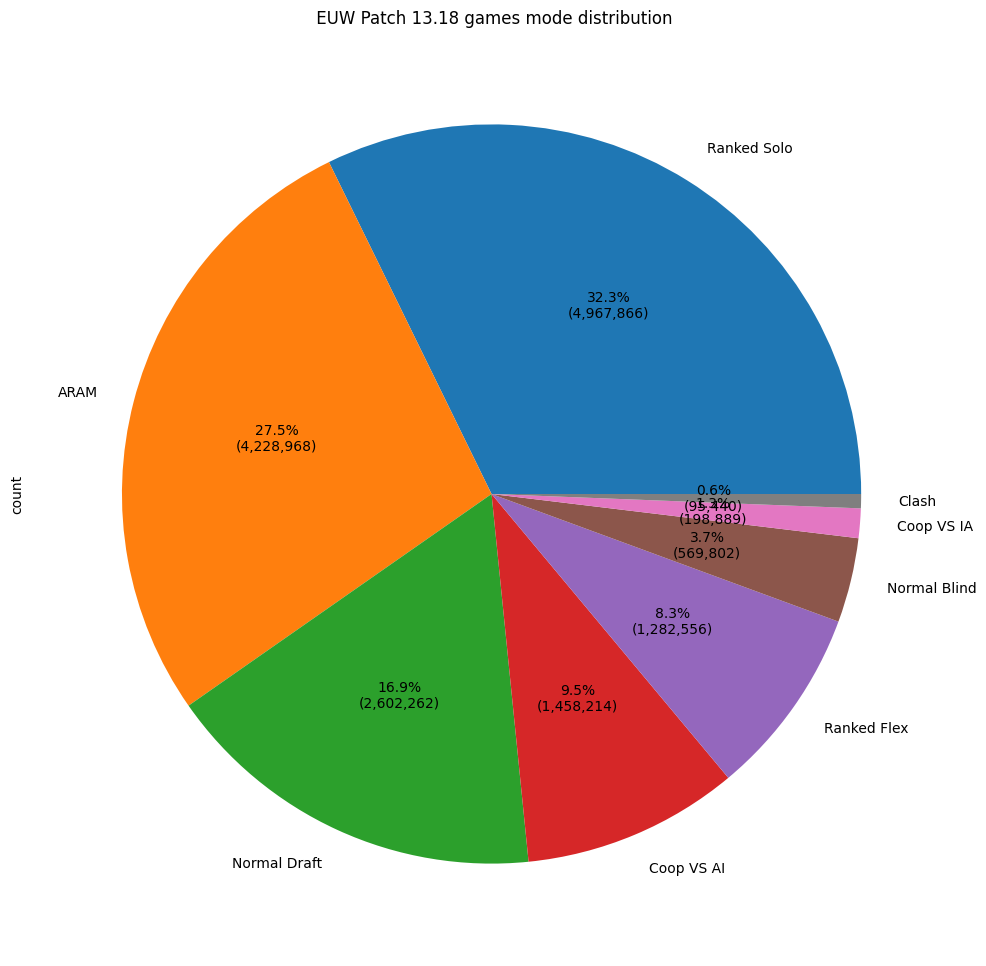

In [92]:
import numpy as np

def format_pct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)


df[df["queueId"] > 0]["mode"].value_counts().plot.pie(figsize=(12, 12), autopct=lambda pct: format_pct(pct, df["mode"].value_counts()), title=" EUW Patch 13.18 games mode distribution")

Exploring game duration in a histogram : 

<Axes: >

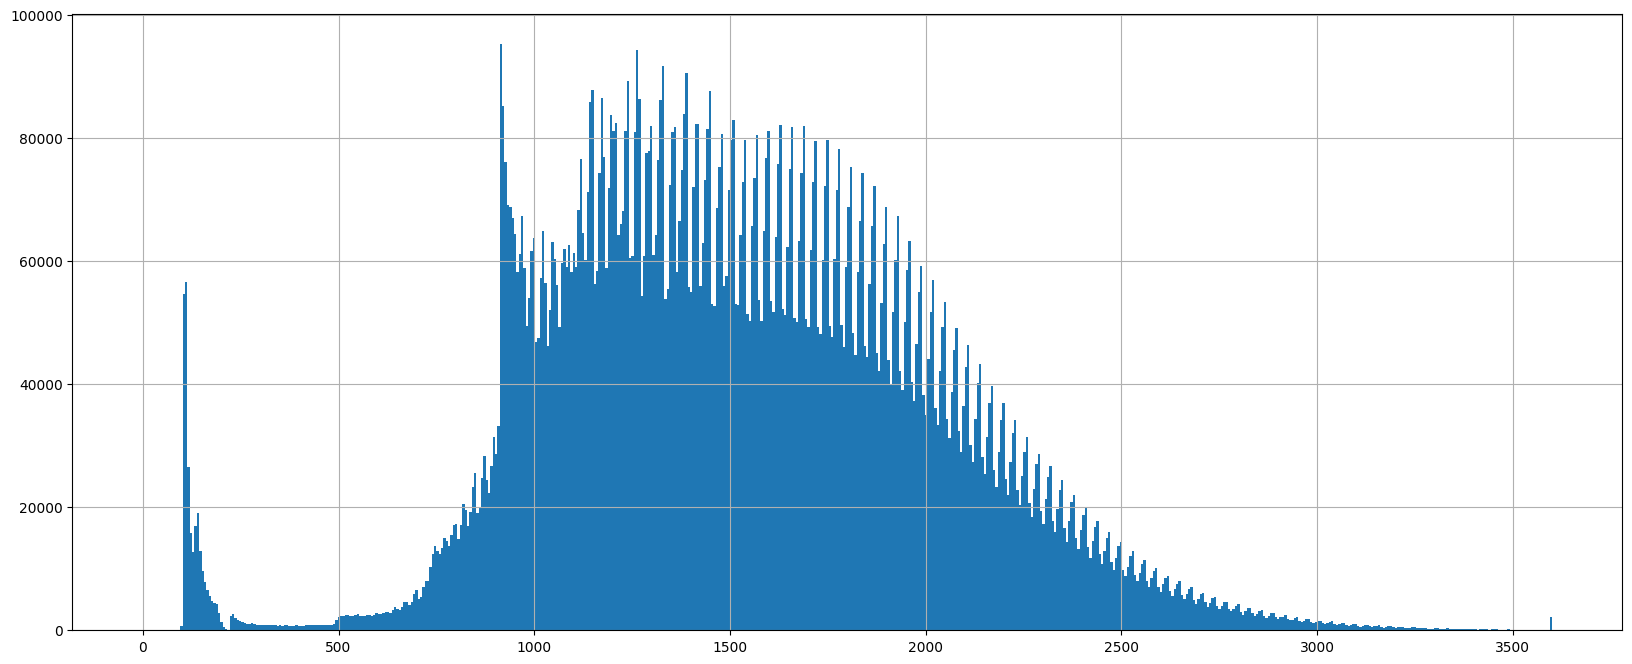

In [8]:
df["gameDuration"].clip(upper=3600).hist(bins=600, figsize=(20,8))

We can see various events : 
 - First, the remake window until 210 seconds with a noticeable notch at the end
 - Then a period during which surrender is possible if there is an AFK but it will not be a remake
 - At 8 minutes (480 seconds) there is the surrender window opening for ARAM
 - At 15 minutes (900 seconds), early surrender window for Classic mode

In [78]:
df[df["gameDuration"] < 240]["gameDuration"].shape[0], df[df["gameDuration"] < 240]["gameDuration"].shape[0] / df["gameDuration"].shape[0]

(271018, 0.017594001558036875)

More than 270k games are remakes, which is \~1.7% of the games.

## Subject : Early game AFK

I played some ARAM recently and figured that player were rarely all there at the game start, and I wanted to know if it was only an impression or a more general trend.

For this study, I will use the first item bought timing as an indicator for a player being "ready". It has a lot of drawbacks, such as a player being able to be AFK after buying items, or a player taking a lot of time to pick *all* starter items, but I prefer to play in the otpimistic side. It is also the most granular data we can obtain from the API as the position information is only available every 60 seconds.

The first idea is to know when all the players in the game are ready : 

In [9]:
df["t9_first_item_purchase"].describe()

count    1.540400e+07
mean     8.131792e+04
std      1.396199e+05
min      0.000000e+00
25%      2.612500e+04
50%      3.652900e+04
75%      5.597000e+04
max      3.547922e+06
Name: t9_first_item_purchase, dtype: float64

Plotted as a candle : 

<Axes: >

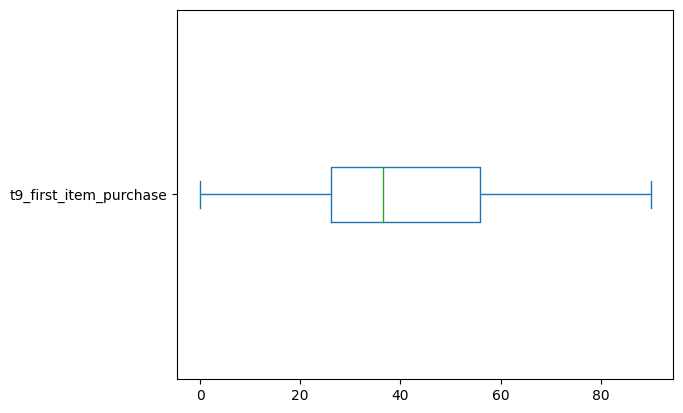

In [10]:
(df["t9_first_item_purchase"] / 1000).clip(upper=90).plot.box(vert=False)

This show already players being very late in the games : more half of the games have all their player after 30 seconds. As a reminder, game start at 15 seconds, even 14 in ARAM.

Adding a field to represent the game start given the mode : 

In [14]:
df["game_start"] = 15000
df.loc[df["mode"] == "ARAM","game_start"] = 14000

Now, how many games start with all players ready?

In [15]:
df.loc[df["t9_first_item_purchase"] < df["game_start"]].shape[0]

269897

In [16]:
df.loc[df["t9_first_item_purchase"] < df["game_start"]].shape[0] / df.shape[0]

0.017521228252401974

Maybe all players ready at 60 seconds?

In [82]:
df.loc[df["t9_first_item_purchase"] < 60000].shape[0]

11944085

In [83]:
df.loc[df["t9_first_item_purchase"] < 60000].shape[0] / df.shape[0]

0.7753885354453389

At minion spawn?

In [84]:
df.loc[df["t9_first_item_purchase"] < 65000].shape[0] / df.shape[0]

0.7989879252142301

Less than 1.8%, across all games and all modes in EUW. Which is ridiculously low.

Considering only 9, 8 and 7 players ready : 

In [79]:
df.loc[df["t8_first_item_purchase"] < df["game_start"]].shape[0] / df.shape[0]

0.0886678135549208

In [80]:
df.loc[df["t7_first_item_purchase"] < df["game_start"]].shape[0] / df.shape[0]

0.23522656452869384

In [81]:
df.loc[df["t6_first_item_purchase"] < df["game_start"]].shape[0] / df.shape[0]

0.43721156842378606

Some might argue that you do not have to be ready at exactly 15 seconds because nothing happens before 1:30. This is wrong for one reason : First Blood

### First blood

First blood can happen very early, and that is especially true in ARAM which now offers portal to get into fight very early.

In [18]:
df.loc[df["mode"] == "Ranked Solo"].loc[df["first_blood"] > 0]["first_blood"].describe()

count    4.866797e+06
mean     1.596894e+05
std      6.270601e+04
min      2.862600e+04
25%      1.271250e+05
50%      1.624550e+05
75%      1.954580e+05
max      8.159440e+05
Name: first_blood, dtype: float64

In [19]:
df.loc[df["mode"] == "ARAM"].loc[df["first_blood"] > 0]["first_blood"].describe()

count    4.224014e+06
mean     6.563152e+04
std      3.074603e+04
min      2.315600e+04
25%      4.264700e+04
50%      5.891900e+04
75%      8.010000e+04
max      6.281220e+05
Name: first_blood, dtype: float64

First blood can occur as early as 23 seconds in ARAM.

In [20]:
df.loc[df["mode"] == "ARAM"].loc[df["t9_first_item_purchase"] < 23000].shape[0] / df.loc[df["mode"] == "ARAM"].shape[0]

0.12526801285231895

And only 12.5% of the ARAM games have all their players ready at 23 seconds. Of course, players should not engage into fight and risking to get killed if all their allies are not ready, but that means the game is already negatively impacted due to AFK players.

First, focus on three major mode type : ARAM, Ranked (Solo and Flex) and Normal (Blind and Draft)

In [21]:
df_aram = df.loc[df["mode"] == "ARAM"]
df_ranked = df.loc[(df["mode"] == "Ranked Solo") + (df["mode"] == "Ranked Flex")]
df_normal = df.loc[(df["mode"] == "Normal Blind") + (df["mode"] == "Normal Draft")]

Plotting distribution of "All players ready" and First blood for each types : 

Text(0.5, 1.0, 'EUW 13.8 distribution by game mode for First Blood and All Players Ready timings')

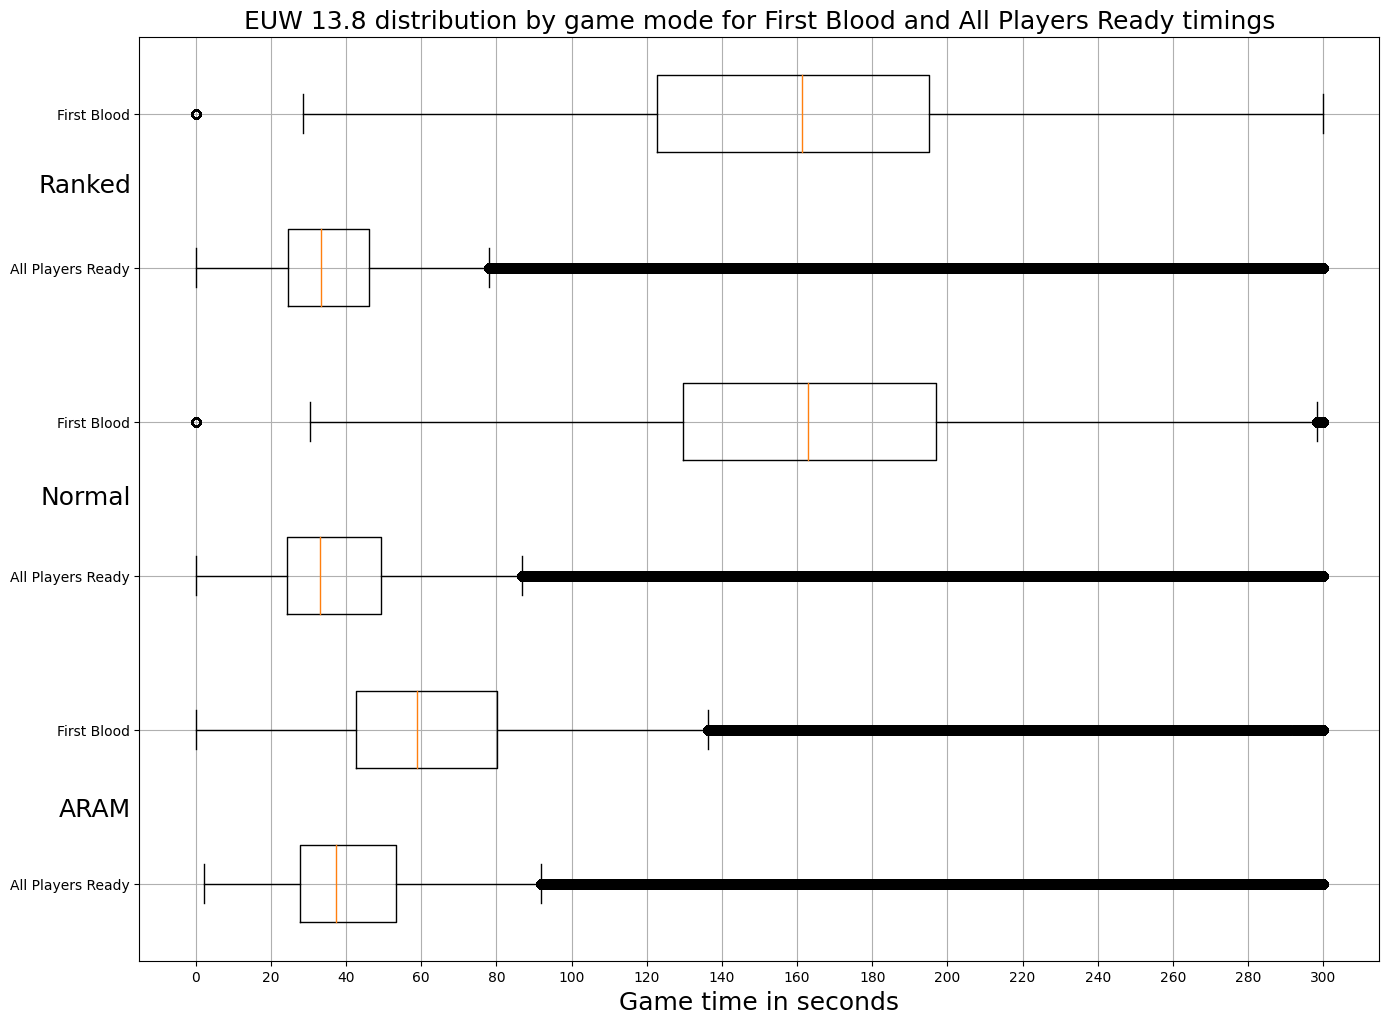

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
plt.boxplot([
        (df_aram["t9_first_item_purchase"] / 1000).clip(upper=300), 
        (df_aram["first_blood"] / 1000).clip(upper=300), 
        (df_normal["t9_first_item_purchase"] / 1000).clip(upper=300), 
        (df_normal["first_blood"] / 1000).clip(upper=300), 
        (df_ranked["t9_first_item_purchase"] / 1000).clip(upper=300), 
        (df_ranked["first_blood"] / 1000).clip(upper=300), 
    ], 
    labels = ["All Players Ready", "First Blood", "All Players Ready", "First Blood", "All Players Ready", "First Blood"],
    vert=False,
)
plt.grid()
plt.xticks([i for i in range(0,301,20)])
plt.text(0.12, 0.75, "Ranked", fontsize=18, transform=plt.gcf().transFigure, ha="right")
plt.text(0.12, 0.49, "Normal", fontsize=18, transform=plt.gcf().transFigure, ha="right")
plt.text(0.12, 0.23, "ARAM", fontsize=18, transform=plt.gcf().transFigure, ha="right")
plt.xlabel("Game time in seconds", fontsize=18)
plt.title("EUW 13.8 distribution by game mode for First Blood and All Players Ready timings", fontsize=18)

This shows a noticeable overlap between first blood tendencies and not having all players ready. This is even major in ARAM.

We can also calculate how many first bloods happen without all players ready : 

In [27]:
df_aram.loc[df_aram["t9_first_item_purchase"] > df_aram["first_blood"]].shape[0]

1001182

In [75]:
df_aram.loc[df_aram["t9_first_item_purchase"] > df_aram["first_blood"]].shape[0] / df_aram.shape[0]

0.23677886036654555

More than one out of 5 first bloods, almost a quarter, happens without all the player being ready.

In [30]:
df_aram.loc[df_aram["t9_first_item_purchase"] + 5000 > df_aram["first_blood"]].shape[0]

1230977

In [31]:
df_aram.loc[df_aram["t9_first_item_purchase"] + 5000 > df_aram["first_blood"]].shape[0] / df_aram.shape[0]

0.2911252211859873

If we consider a travel time of 5 seconds to the lane, it goes up to 30%.

If we look at ranked games : 

In [74]:
df_ranked.loc[df_ranked["t9_first_item_purchase"] > df_ranked["first_blood"]].shape[0] / df_ranked.shape[0]

0.04640310194614094

In ranked, almost 5% of the first bloods are made without everyone ready.

# Players

All players do not have the same standards, and we should expect that some are consistently on time, while others are consistently late. How much is that exactly?

We need to first group stats by player. For practical reason for later studies, I replace the value "0" by "99999999", as the "0" represents a player never buying an item.

In [34]:
players_stats = {}
for k, v in df.iterrows():
    for i in range(0,10):
        if not v[f"participant_{i}"] in players_stats:
            players_stats[v[f"participant_{i}"]] = []
        
        players_stats[v[f"participant_{i}"]].append(v[f"p{i}_first_item_purchase"] if v[f"p{i}_first_item_purchase"] > 0 else 99999999)

Now we need to overview the stats for each player. First, what is the median of each player?

In [35]:
import statistics
players_median = [statistics.median(players_stats[i]) for i in players_stats]

In [36]:
pd.Series(players_median).describe()

count    6.036992e+06
mean     2.819329e+05
std      4.895865e+06
min      5.670000e+02
25%      8.556000e+03
50%      1.193350e+04
75%      1.674700e+04
max      1.000000e+08
dtype: float64

We can see that almost 75% of the players are ready to play at least half of their games before 15 seconds. But focusing on half a player's game is not really revealing. If we want to show how many players are consistently on time, we should focus more on a "90% of the games" goal, i.e. the 9th decile. However, the stats will be biased if we take players without enough games, so we will filter out players with less than 10 games in the patch.

In [61]:
players_median_10_games = [statistics.median(players_stats[i]) for i in players_stats if len(players_stats[i]) >= 10]
players_9th_decile_10_games = [statistics.quantiles(players_stats[i], n=10)[-1] for i in players_stats if len(players_stats[i]) >= 10]

In [38]:
pd.Series(players_median_10_games).describe()

count    3.629870e+06
mean     2.550381e+04
std      9.998204e+05
min      6.130000e+02
25%      8.546000e+03
50%      1.148500e+04
75%      1.544200e+04
max      1.000000e+08
dtype: float64

Filtering out those who do not play a lot already show better stats overall.

In [62]:
s_players_9th_decile_10_games = pd.Series(players_9th_decile_10_games)
s_players_9th_decile_10_games.describe()

count    3.629870e+06
mean     5.844633e+05
std      6.278462e+06
min      1.146000e+03
25%      2.054400e+04
50%      2.784680e+04
75%      3.885520e+04
max      1.000000e+08
dtype: float64

But on the "90% of the games" goal, we can see why less than 2% of the games begin without all the players ready. Less than 25% of the players can say they are quite consistent at being ready 20 seconds in the game.

In [45]:
s_players_9th_decile_10_games[s_players_9th_decile_10_games < 15000].shape[0] / s_players_9th_decile_10_games.shape[0]

0.07455804202354355

More precisely, less than 8% of the players are ready at 15 seconds on 90% of their games.

On the other side, we can also count how many players are consistently late.

In [63]:
players_1st_decile_10_games = [statistics.quantiles(players_stats[i], n=10)[0] for i in players_stats if len(players_stats[i]) >= 10]

In [64]:
s_players_1st_decile_10_games = pd.Series(players_1st_decile_10_games)
s_players_1st_decile_10_games.describe()

count    3.629870e+06
mean     1.008161e+04
std      5.191039e+05
min      4.608000e+02
25%      3.711000e+03
50%      4.805900e+03
75%      6.372000e+03
max      1.000000e+08
dtype: float64

In [65]:
s_players_1st_decile_10_games[s_players_1st_decile_10_games > 15000].shape[0] / s_players_1st_decile_10_games.shape[0]

0.024020419464057943

In [50]:
players_stats_aram = {}
for k, v in df_aram.iterrows():
    for i in range(0,10):
        if not v[f"participant_{i}"] in players_stats_aram:
            players_stats_aram[v[f"participant_{i}"]] = []
        
        players_stats_aram[v[f"participant_{i}"]].append(v[f"p{i}_first_item_purchase"] if v[f"p{i}_first_item_purchase"] > 0 else 99999999)
        
players_stats_normal = {}
for k, v in df_normal.iterrows():
    for i in range(0,10):
        if not v[f"participant_{i}"] in players_stats_normal:
            players_stats_normal[v[f"participant_{i}"]] = []
        
        players_stats_normal[v[f"participant_{i}"]].append(v[f"p{i}_first_item_purchase"] if v[f"p{i}_first_item_purchase"] > 0 else 99999999)
        
players_stats_ranked = {}
for k, v in df_ranked.iterrows():
    for i in range(0,10):
        if not v[f"participant_{i}"] in players_stats_ranked:
            players_stats_ranked[v[f"participant_{i}"]] = []
        
        players_stats_ranked[v[f"participant_{i}"]].append(v[f"p{i}_first_item_purchase"] if v[f"p{i}_first_item_purchase"] > 0 else 99999999)

In [94]:
players_1st_decile_10_games_aram = [statistics.quantiles(players_stats_aram[i], n=10)[0] for i in players_stats_aram if len(players_stats_aram[i]) >= 10]
players_median_10_games_aram = [statistics.median(players_stats_aram[i]) for i in players_stats_aram if len(players_stats_aram[i]) >= 10]
players_9th_decile_10_games_aram = [statistics.quantiles(players_stats_aram[i], n=10)[-1] for i in players_stats_aram if len(players_stats_aram[i]) >= 10]

players_1st_decile_10_games_normal = [statistics.quantiles(players_stats_normal[i], n=10)[0] for i in players_stats_normal if len(players_stats_normal[i]) >= 10]
players_median_10_games_normal = [statistics.median(players_stats_normal[i]) for i in players_stats_normal if len(players_stats_normal[i]) >= 10]
players_9th_decile_10_games_normal = [statistics.quantiles(players_stats_normal[i], n=10)[-1] for i in players_stats_normal if len(players_stats_normal[i]) >= 10]

players_1st_decile_10_games_ranked = [statistics.quantiles(players_stats_ranked[i], n=10)[0] for i in players_stats_ranked if len(players_stats_ranked[i]) >= 10]
players_median_10_games_ranked = [statistics.median(players_stats_ranked[i]) for i in players_stats_ranked if len(players_stats_ranked[i]) >= 10]
players_9th_decile_10_games_ranked = [statistics.quantiles(players_stats_ranked[i], n=10)[-1] for i in players_stats_ranked if len(players_stats_ranked[i]) >= 10]

Time for big summary figure.

Text(0.5, 0.96, 'Share of players readiness across game time')

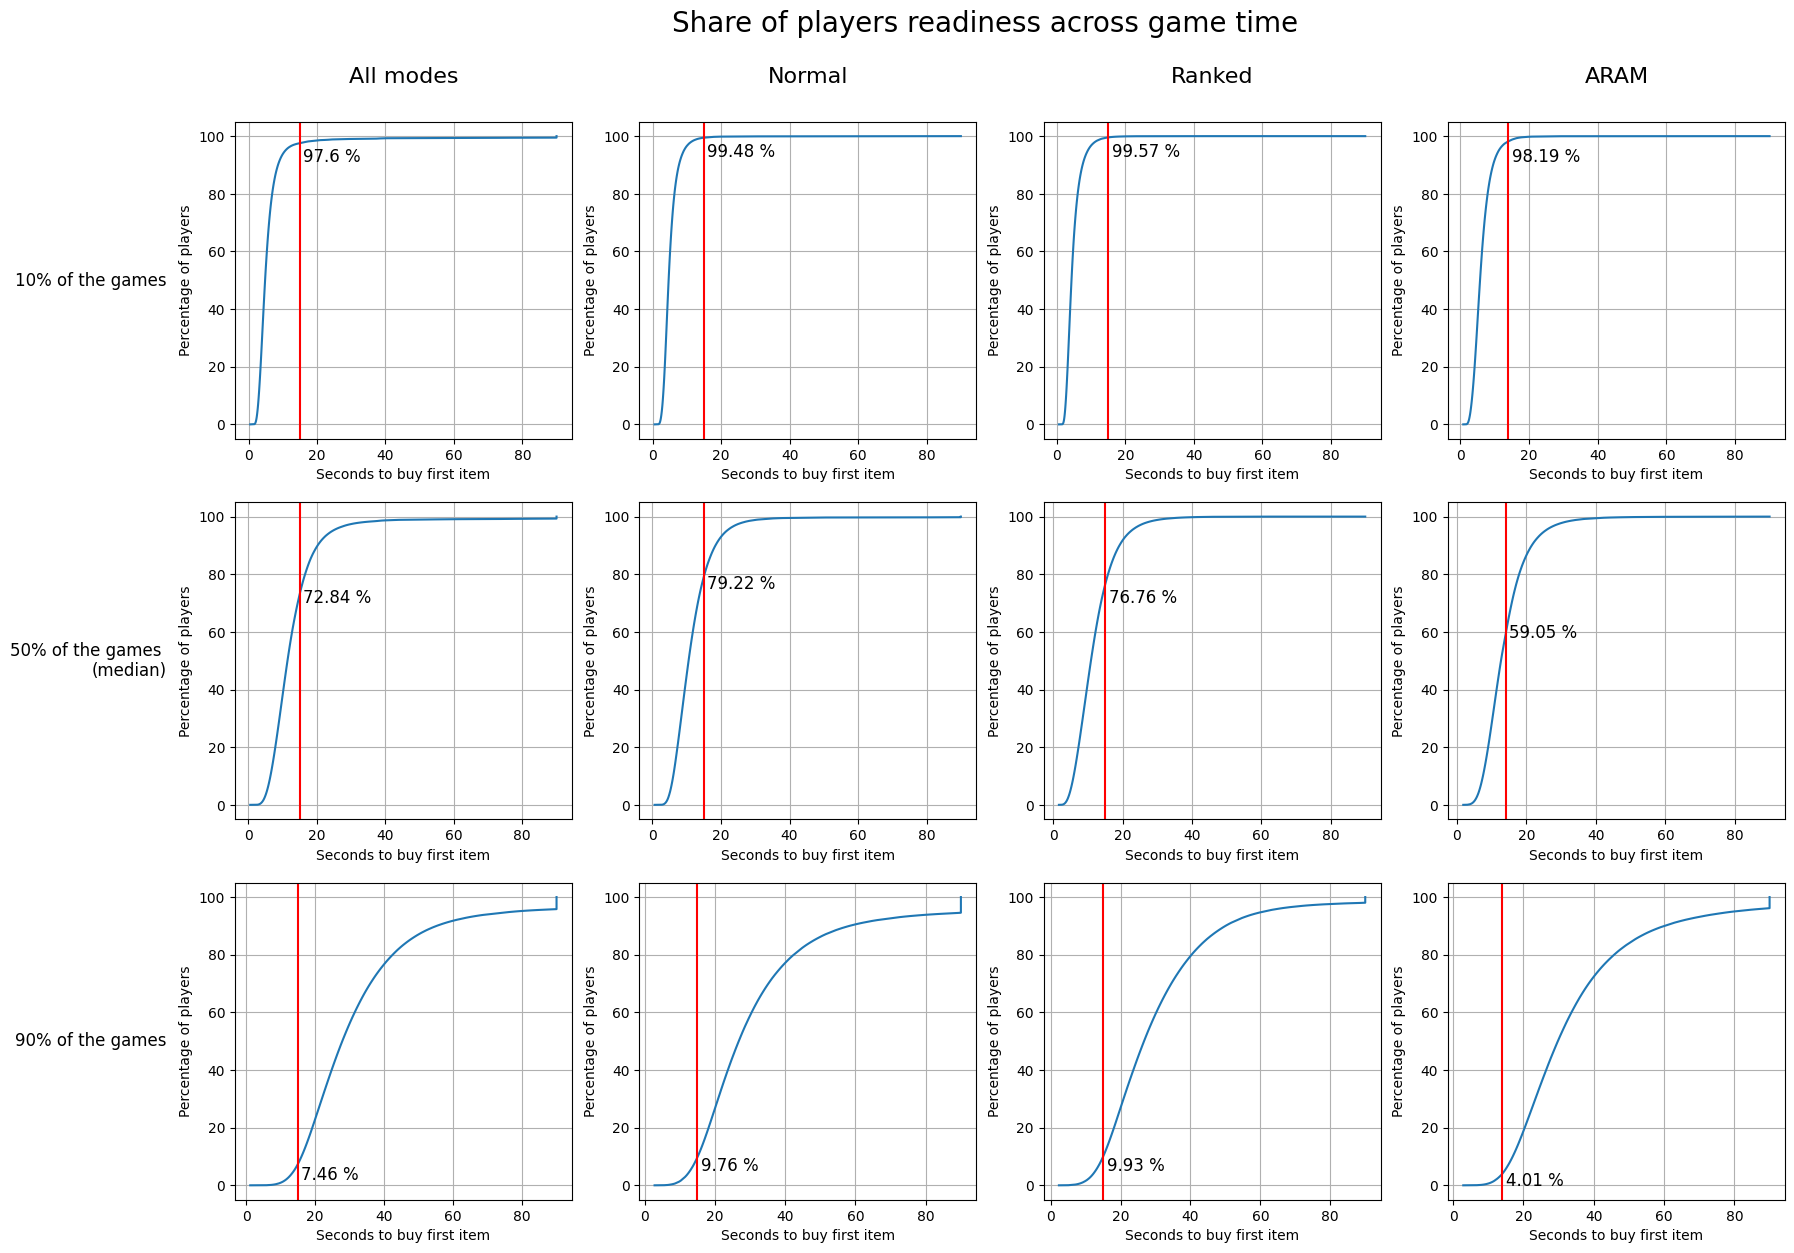

In [86]:
fig, ax = plt.subplots(3, 4, figsize=(20, 14))

# Columns and rows titles
pad = 5
ax[0][0].annotate("All modes", xy=(0.5, 1.1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            fontsize=16, ha='center', va='baseline')

ax[0][1].annotate("Normal", xy=(0.5, 1.1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            fontsize=16, ha='center', va='baseline')

ax[0][2].annotate("Ranked", xy=(0.5, 1.1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            fontsize=16, ha='center', va='baseline')

ax[0][3].annotate("ARAM", xy=(0.5, 1.1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            fontsize=16, ha='center', va='baseline')


ax[0][0].annotate("10% of the games", xy=(0, 0.5), xytext=(-ax[0][0].yaxis.labelpad - pad, 0),
            xycoords=ax[0][0].yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center')

ax[1][0].annotate("50% of the games \n(median)", xy=(0, 0.5), xytext=(-ax[1][0].yaxis.labelpad - pad, 0),
            xycoords=ax[1][0].yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center')

ax[2][0].annotate("90% of the games", xy=(0, 0.5), xytext=(-ax[2][0].yaxis.labelpad - pad, 0),
            xycoords=ax[2][0].yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center')



# All modes data
## 10% of the games
df_temp = (pd.Series(players_1st_decile_10_games) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[0][0].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[0][0].axvline(x = 15, color = 'r')
ax[0][0].set_xlabel("Seconds to buy first item")
ax[0][0].set_ylabel("Percentage of players")
ax[0][0].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[0][0].annotate(value, xy=(16, 91), size='large')

## 50% of the games
df_temp = (pd.Series(players_median_10_games) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[1][0].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[1][0].axvline(x = 15, color = 'r')
ax[1][0].set_xlabel("Seconds to buy first item")
ax[1][0].set_ylabel("Percentage of players")
ax[1][0].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[1][0].annotate(value, xy=(16, 70), size='large')

## 90% of the games
df_temp = (pd.Series(players_9th_decile_10_games) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[2][0].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[2][0].axvline(x = 15, color = 'r')
ax[2][0].set_xlabel("Seconds to buy first item")
ax[2][0].set_ylabel("Percentage of players")
ax[2][0].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[2][0].annotate(value, xy=(16, 2), size='large')




# Normal
## 10% of the games
df_temp = (pd.Series(players_1st_decile_10_games_normal) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[0][1].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[0][1].axvline(x = 15, color = 'r')
ax[0][1].set_xlabel("Seconds to buy first item")
ax[0][1].set_ylabel("Percentage of players")
ax[0][1].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[0][1].annotate(value, xy=(16, 93), size='large')

## 50% of the games
df_temp = (pd.Series(players_median_10_games_normal) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[1][1].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[1][1].axvline(x = 15, color = 'r')
ax[1][1].set_xlabel("Seconds to buy first item")
ax[1][1].set_ylabel("Percentage of players")
ax[1][1].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[1][1].annotate(value, xy=(16, 75), size='large')

## 90% of the games
df_temp = (pd.Series(players_9th_decile_10_games_normal) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[2][1].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[2][1].axvline(x = 15, color = 'r')
ax[2][1].set_xlabel("Seconds to buy first item")
ax[2][1].set_ylabel("Percentage of players")
ax[2][1].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[2][1].annotate(value, xy=(16, 5), size='large')





# Ranked
## 10% of the games
df_temp = (pd.Series(players_1st_decile_10_games_ranked) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[0][2].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[0][2].axvline(x = 15, color = 'r')
ax[0][2].set_xlabel("Seconds to buy first item")
ax[0][2].set_ylabel("Percentage of players")
ax[0][2].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[0][2].annotate(value, xy=(16, 93), size='large')

## 50% of the games
df_temp = (pd.Series(players_median_10_games_ranked) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[1][2].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[1][2].axvline(x = 15, color = 'r')
ax[1][2].set_xlabel("Seconds to buy first item")
ax[1][2].set_ylabel("Percentage of players")
ax[1][2].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[1][2].annotate(value, xy=(16, 70), size='large')

## 90% of the games
df_temp = (pd.Series(players_9th_decile_10_games_ranked) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[2][2].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[2][2].axvline(x = 15, color = 'r')
ax[2][2].set_xlabel("Seconds to buy first item")
ax[2][2].set_ylabel("Percentage of players")
ax[2][2].grid()

value = str(round(df_temp[0][df_temp[0] < 15].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[2][2].annotate(value, xy=(16, 5), size='large')





# ARAM
## 10% of the games
df_temp = (pd.Series(players_1st_decile_10_games_aram) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[0][3].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[0][3].axvline(x = 14, color = 'r')
ax[0][3].set_xlabel("Seconds to buy first item")
ax[0][3].set_ylabel("Percentage of players")
ax[0][3].grid()

value = str(round(df_temp[0][df_temp[0] < 14].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[0][3].annotate(value, xy=(15, 91), size='large')

## 50% of the games
df_temp = (pd.Series(players_median_10_games_aram) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[1][3].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[1][3].axvline(x = 14, color = 'r')
ax[1][3].set_xlabel("Seconds to buy first item")
ax[1][3].set_ylabel("Percentage of players")
ax[1][3].grid()

value = str(round(df_temp[0][df_temp[0] < 14].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[1][3].annotate(value, xy=(15, 58), size='large')

## 90% of the games
df_temp = (pd.Series(players_9th_decile_10_games_aram) / 1000).clip(upper=90).sort_values().reset_index().drop(columns=["index"])
ax[2][3].plot(df_temp[0], df_temp.index/df_temp.index.max() * 100)
ax[2][3].axvline(x = 14, color = 'r')
ax[2][3].set_xlabel("Seconds to buy first item")
ax[2][3].set_ylabel("Percentage of players")
ax[2][3].grid()

value = str(round(df_temp[0][df_temp[0] < 14].shape[0] / df_temp[0].shape[0] * 100, 2)) + " %"
ax[2][3].annotate(value, xy=(15, 0), size='large')

fig.suptitle("Share of players readiness across game time", fontsize=20, y=0.96)

Each plot shows the share of player ready by time.  
The top right plot for instance, shows the first decile of games per player in ARAM. It means here that 98.19% of the players are able to be ready in time in at least 1 game out of 10. In another way, 1.8% of ARAM players are not ready at start time in 90% of their games.  
In the bottom right plot, still for ARAM, we see that only 4% of the players are consistently ready at start time. We also see that this same information for normal and ranked games is up to almost 10%.

In [93]:
print("ARAM players", len(players_median_10_games_aram))
print("Normal players", len(players_median_10_games_normal))
print("Ranked players", len(players_median_10_games_ranked))

ARAM players 1225481
Normal players 994530
Ranked players 1814168
